### George Shi

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, metrics, datasets

### Acquring Player Data

In [2]:
player_data = pd.read_csv('player_data.csv')
# print(np.shape(player_data))
players = pd.read_csv('Players.csv')
# print(np.shape(players))
stats = pd.read_csv('Seasons_Stats.csv')
# print(np.shape(stats))
# print(stats)

Data was acquired from https://www.kaggle.com/drgilermo/nba-players-stats and includes NBA data on players from 1950 to 2017

player_data.csv contains: player name, year_start, year_end, position, height, weight, birth_date, and college.

Players.csv contains: PlayerPlayer's full name (first and last), heightHeight in cm, weightWeight in kg, collageThe college said player attended, bornBirthdate of the player, birth_cityCity where the player was born, and birth_stateState where the player was born.

Seasons_Stats.csv contains 53 columns of player stats.

### Dropping stats that I don't think are important for predicting a player's position

In [3]:
new_stats = stats.drop(['blanl', 'blank2', 'Tm','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'], axis=1) 
new_stats.head() #Just want to see a brief preview of the data

,Unnamed: 0,Year,Player,Pos,Age,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,13.0,NaN,NaN,NaN,0.308,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


Still contains NaN values since the NBA has changed how they record stats and some players may have never played that season.

### Combining Stats and Players Data

In [4]:
#Merge new_stats and Players by matching player names to one another in data set since new_stats doesn't contain data like height and weight
data = pd.merge(new_stats, players[['Player', 'height', 'weight']], left_on='Player', right_on='Player', right_index=False,
      how='left', sort=False).fillna(value=0)

#Remove players with less than 300 playing minutes since they have very skewed stats and would most likely be outliers
data = data[(data['MP'] > 300)] 

#Reset the index of the data, and use the default one instead
data.reset_index(inplace=True, drop=True)

#Some of the names of players have '*' for some reason so I'm just gonna get rid of it
data['Player'] = data['Player'].str.replace('*','')

### One Important Issue that needs to be addressed

Some players like LeBron or Russell Westbrook see a lot more playing time than others. Due to that the stats that represent total values like FG or STL will be signifcantly higher than those who see less playing time. The first time I ran this data, I did not account for this, but that made things complicated. Instead, I'm going to take the per 40 of these stats to approximate what these players would have had had they played 40 minutes every game. This way we don't judge players based playing time, but rather their characteristics.

In [5]:
totals = ['PER', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
for col in totals:
    data[col] = 40 * data[col] / data['MP']

#### For my project, I want to group players into 3 different groups based on years they played (1990-1999, 2000-2009, 2010-2017)

In [6]:
# #Data 1 is just for players who played from 1990 to 1999
# data_1 = data[(data['Year'] == 1990)+(data['Year'] == 1991)+(data['Year'] == 1992)+(data['Year'] == 1993)+(data['Year'] == 1994)+(data['Year'] == 1995)+(data['Year'] == 1996)+(data['Year'] == 1997)+(data['Year'] == 1998)+(data['Year'] == 1999)]
# data_1.tail()
# #Data 2 is just for players who played from 2000-2009
# data_2 = data[(data['Year'] == 2000)+(data['Year'] == 2001)+(data['Year'] == 2002)+(data['Year'] == 2003)+(data['Year'] == 2004)+(data['Year'] == 2005)+(data['Year'] == 2006)+(data['Year'] == 2007)+(data['Year'] == 2008)+(data['Year'] == 2009)]
# data_2.tail()
# #Data 3 is just for players who played from 2010-2017
# data_3 = data[(data['Year'] == 2010)+(data['Year'] == 2011)+(data['Year'] == 2012)+(data['Year'] == 2013)+(data['Year'] == 2014)+(data['Year'] == 2015)+(data['Year'] == 2016)+(data['Year'] == 2017)]
# data_3.tail()

data_1 = data[(data['Year'] == 2010)+(data['Year'] == 2011)+(data['Year'] == 2012)+(data['Year'] == 2013)]
data_2 = data[(data['Year'] == 2014)+(data['Year'] == 2015)+(data['Year'] == 2016)+(data['Year'] == 2017)]


/Users/georgeshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


Ideally I wanted it to run for 1990-1999, 2000-2009, and 2010-2017 so that I could get a comparison of how player positions have changed, but it takes forever for my ppca to converge and it would make this code wayyyyyyyyy too long. So I will instead break the 2010-2017 data into two for 2010-2013 and 2014-2017 since being the basketball fan that I am, I have noticed a drastic change in style in the last 4 years with a much higher reliance on the 3 point bomb and less reliance on the big man; however, I will make the side note that if you want to compare this with the other data from 1990-1999 and 2000-2009, you can do so by simply running it for the lines I commented out in the same process, but just know it will take a lotttttttt of time. 

### Processing data to work for dimension reduction

In [7]:
#To use this data, we have to drop factors that aren't important
X = data_1.drop(['Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)
#Used _get_numeric_data().dropna(axis=1) to drop anything that is text like player name
X1 = X._get_numeric_data().dropna(axis=1)

### Modified Python Package

In [8]:
import sys
sys.path.append('../')

Issue is with PPCA code that is online for almost every other implementation we have used or is available is that it doesn't work well with something that is 37 dimensions or it need axis specifications so I modified https://github.com/cangermueller/ppca, https://github.com/ymcdull/ppca/blob/master/probit_ppca.py, and https://github.com/allentran/pca-magic/blob/master/ppca/_ppca.py to work for my specific data set. 

In [9]:
from ppca import PPCA

In [104]:
# %load ppca
import numpy as np
from scipy import special
from numpy.random import randn
from numpy.matlib import repmat

## update W, X and tau
class PPCA:
    def __init__(self, D = 2, n_iters = 100, verbose = False):
        self.D = D
        self.n_iters = n_iters
        self.verbose = verbose
        
    def _init_paras(self, N, M, D):
        self.a = 1.0
        self.b = 1.0
        self.e_tau = self.a / self.b
        self.e_w = randn(M, D)
        self.e_wwt = np.zeros((D, D, M))
        for m in range(M):
            ## use np.newaxis here to transfer numpy array from 1D to 2D
            self.e_wwt[:, :, m] = np.eye(D) + self.e_w[m, :][np.newaxis].T.dot(self.e_w[m, :][np.newaxis])
        self.tol = 1e-3
        self.lbs = []
        self.e_X = np.zeros((N, D))
        self.e_XXt = np.zeros((D, D, N))

    def _update_X(self, Y, N, D):
        self.sigx = np.linalg.inv(np.eye(D) + self.e_tau * np.sum(self.e_wwt, axis = 2))
        for n in range(N):
            self.e_X[n, :] = self.e_tau * self.sigx.dot(np.sum(self.e_w * np.tile(Y[n, :], (D, 1)).T, axis = 0))
            self.e_XXt[:, :, n] = self.sigx + self.e_X[n, :][np.newaxis].T.dot(self.e_X[n, :][np.newaxis])

    def _update_W(self, Y, M, D):
        self.sigw = np.linalg.inv(np.eye(D) + self.e_tau * np.sum(self.e_XXt, axis = 2))
        for m in range(M):
            self.e_w[m, :] = self.e_tau * self.sigw.dot(np.sum(self.e_X * np.tile(Y[:, m], (D, 1)).T, axis = 0))
            self.e_wwt[:, :, m] = self.sigw + self.e_w[m, :][np.newaxis].T.dot(self.e_w[m, :][np.newaxis])

    def _update_tau(self, Y, M, N):
        self.e = self.a + N * M * 1.0 / 2
        outer_expect = 0
        for n in range(N):
            for m in range(M):
                outer_expect = outer_expect \
                                + np.trace(self.e_wwt[:, :, m].dot(self.sigx)) \
                                + self.e_X[n, :][np.newaxis].dot(self.e_wwt[:, :, m]).dot(self.e_X[n, :][np.newaxis].T)[0][0]
        self.f = self.b + 0.5 * np.sum(Y ** 2) - np.sum(Y * self.e_w.dot(self.e_X.T).T) + 0.5 * outer_expect
        self.e_tau = self.e / self.f
        self.e_log_tau = np.mean(np.log(np.random.gamma(self.e, 1/self.f, size=1000)))
    
    def lower_bound(self,Y, M, N, D):
        LB = self.a * np.log(self.b) + (self.a - 1) * self.e_log_tau - self.b * self.e_tau - special.gammaln(self.a)
        LB = LB - (self.e * np.log(self.f) + (self.e - 1) * self.e_log_tau - self.f * self.e_tau - special.gammaln(self.e))
        for n in range(N):
            LB = LB + (-(D*0.5)*np.log(2*np.pi) - 0.5 * (np.trace(self.sigx) + self.e_X[n, :][np.newaxis].dot(self.e_X[n, :][np.newaxis].T)[0][0]))
            LB = LB - (-(D*0.5)*np.log(2*np.pi) - 0.5 * np.log(np.linalg.det(self.sigx)) - 0.5 * D)
        for m in range(M):
            LB = LB + (-(D*0.5)*np.log(2*np.pi) - 0.5 * (np.trace(self.sigw) + self.e_w[m, :][np.newaxis].dot(self.e_w[m, :][np.newaxis].T)[0][0]))
            LB = LB - (-(D*0.5)*np.log(2*np.pi) - 0.5 * np.log(np.linalg.det(self.sigw)) - 0.5 * D)
        outer_expect = 0
        for n in range(N):
            for m in range(M):
                outer_expect = outer_expect \
                                + np.trace(self.e_wwt[:, :, m].dot(self.sigx)) \
                                + self.e_X[n, :][np.newaxis].dot(self.e_wwt[:, :, m]).dot(self.e_X[n, :][np.newaxis].T)[0][0]

        LB = LB + ( \
            -(N * M * 1.0 / 2) * np.log(2 * np.pi) + (N * M * 1.0 / 2) * self.e_log_tau \
            - 0.5 * self.e_tau * (np.sum(Y**2) - 2 * np.sum(Y * self.e_w.dot(self.e_X.T).T) + outer_expect))
        return LB
    
    def _update(self, Y, N, M, D):
        self._update_X(Y, N, D)
        self._update_W(Y, M, D)
        self._update_tau(Y, M, N)
        LB = self.lower_bound(Y, M, N, D)
        self.lbs.append(LB)
        if self.verbose:
            string = "Step: {}"
            print(string.format(LB))
             
    def fit(self, Y):
        N, M = Y.shape
        D = self.D
        self._init_paras(N, M, D)

        for it in range(self.n_iters):
            self._update(Y, N, M, D)
            if self.verbose:
                print(it)
            if it >= 1:
                if np.abs(self.lbs[it] - self.lbs[it - 1]) < self.tol:
                    break

    def recon(self):
        return self.e_X.dot(self.e_w.T)


### Standardize Data

In [10]:
scaler = StandardScaler()
Xsim = scaler.fit_transform(X1)
np.shape(Xsim)

(1747, 37)

In order to use this data for ppca, we need to standardize it so that the individual features do more or less look like standard normally distributed data.

### Fitting Data to PPCA

Now we need to reduce the data to PPCA and 2 components

In [11]:
ppca = PPCA(D = 2, n_iters = 100, verbose = True)
ppca.fit(Xsim)
#Usually converges aroiund 85-95 iterations

Step: -93800.27597261516
0
Step: -79977.89090141506
1
Step: -77213.28438394432
2
Step: -76335.01659988162
3
Step: -76033.89489158487
4
Step: -75892.02805775811
5
Step: -75792.9356687959
6
Step: -75707.81479726228
7
Step: -75629.58625962303
8
Step: -75556.34580415598
9
Step: -75487.41644301786
10
Step: -75422.41985774187
11
Step: -75361.06122109023
12
Step: -75303.0813949286
13
Step: -75248.24752904617
14
Step: -75196.35165733624
15
Step: -75147.21023404355
16
Step: -75100.66311567982
17
Step: -75056.57182998417
18
Step: -75014.81728762279
19
Step: -74975.29714896767
20
Step: -74937.92304371201
21
Step: -74902.617807013
22
Step: -74869.31285642955
23
Step: -74837.94579696168
24
Step: -74808.4583094166
25
Step: -74780.79435187129
26
Step: -74754.89868301908
27
Step: -74730.71570223938
28
Step: -74708.18859029487
29
Step: -74687.25872699851
30
Step: -74667.86535844019
31
Step: -74649.94548251435
32
Step: -74633.43392058794
33
Step: -74618.26354289826
34
Step: -74604.3656150179
35
Step: -7

### Plot Convergence

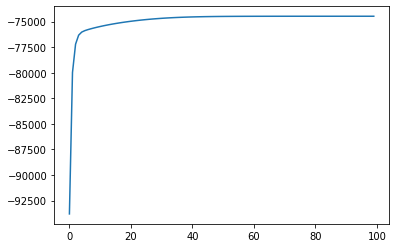

In [12]:
length = len([i for i in ppca.lbs if i != 0])
plt.plot(range(length), ppca.lbs[:length])

### Reconstruct data after reduced by PPCA

In [14]:
X2 = ppca.recon()
print(X2)
np.shape(X2)

[[ 0.06033772 -0.08730994 -0.36458168 ... -0.69288372 -0.33689147
  -0.38846847]
 [-0.07430641  0.12088963  0.44012396 ...  0.78968223  0.46526293
   0.52583593]
 [ 0.03971806  0.07285915 -0.32639379 ... -1.07632715  0.26945022
   0.20678853]
 ...
 [ 0.06914207 -0.0034972  -0.48179015 ... -1.25346621 -0.02214836
  -0.10252073]
 [-0.05027981  0.10975351  0.27928076 ...  0.40131925  0.42017537
   0.45500472]
 [-0.01225257  0.17467723 -0.03001371 ... -0.6061849   0.65993673
   0.63583677]]


(1747, 37)

### First run a KMeans 

Since we already had to write our own KMeans before, I just went ahead and used sklearn's KMeans this time.

In [332]:
from sklearn.cluster import KMeans
#modified KMeans
def kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans = kmeans.fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    score = metrics.silhouette_score(data, labels, metric='euclidean')

    data_dictionary = {
        "labels": labels,
        "centroids": centroids,
        "silhouette_score": score
    }
    return data_dictionary

#Find best silhouette score in given range
def find_best_cluster(data,a,b):
    scores = []
    for i in range(a,b):
        i_clusters = kmeans(data, i)
        sil_score_i = i_clusters['silhouette_score']
        scores.append(sil_score_i)

    sns.set_context('poster', font_scale=1)
    plt.plot(range(a,b), scores)
    plt.title("""Silhouette Score""")
    print("best silhouette score:", np.max(scores))

best silhouette score: 0.3685990084772886


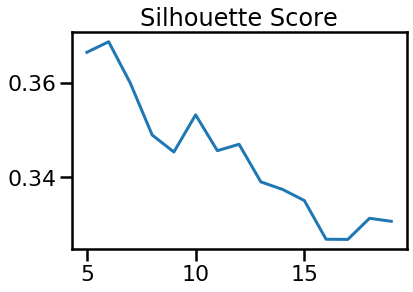

In [333]:
find_best_cluster(X2,5,20)

Based on graph, I will choose 8 clusters

In [142]:
kmean = KMeans(n_clusters=8, random_state=1)
#Fitting the ppca reduced data to KMeans
kmean.fit(X2)
labels = kmean.predict(X2)
labels

array([5, 2, 0, ..., 5, 2, 0], dtype=int32)

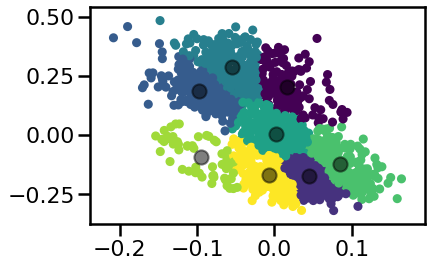

In [18]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=50, cmap='viridis')
centers = kmean.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

The clustering is not perfect since they're not that circular so might be better to use a Gaussian Mixture Instead.

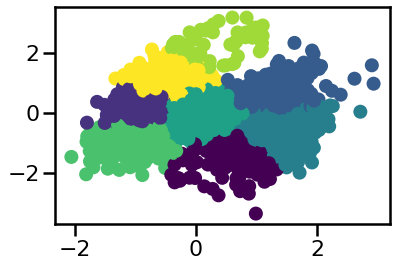

In [19]:
plt.scatter(ppca.e_X[:, 0], ppca.e_X[:, 1], c=labels)

Not the greatest clustering, but at least looks mostly distinct.

In [21]:
group1 = (labels == 0)
cat1 = data_1[group1][['Player']]
print(cat1)

                 Player
14961       Malik Allen
14972      Joel Anthony
14975  Hilton Armstrong
14977    Darrell Arthur
15004        Josh Boone
...                 ...
16655      Lance Thomas
16664      Ronny Turiaf
16666         Ekpe Udoh
16673        Jan Vesely
16705      Tyler Zeller

[149 rows x 1 columns]


Clearly there are repeat names, but that is only because those players switched teams during that season and so they had two rows of data for them and I will keep that so if I have additional time, I can also go through and check if these players played consistently the same style or changed during the season.

### Peform PCA analysis on clusters to determine most important features

In [29]:
def feature_importance(specific_data, nba_data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(specific_data)
    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)
    
    #Played around with how many features are important. 10 seems to capture pretty much anything of value
    features = pd.DataFrame(zip(specific_data.columns, pca.components_[0], np.mean(specific_data), np.mean(nba_data)),
        columns=['Stat', 'Correlation', 'Cluster Average', 'League Average']).sort_values('Correlation', ascending=False).head(10)
    return features

### For Group 1

In [30]:
#Data for just this specific cluster
cluster = data_1[group1].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

#Data for league averages as a comparision
league = data_1.drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.304220,17.747651,13.622954
1,FTr,0.233725,0.351282,0.283643
2,TS%,0.118476,0.491926,0.526508
3,FG%,0.116703,0.460564,0.450417
4,eFG%,0.110107,0.464510,0.490774
5,PF,0.101248,5.137755,3.624738
6,2P%,0.098533,0.466859,0.475215
7,BLK%,0.048981,2.923490,1.606754
8,weight,0.048247,107.953020,99.231254
9,BLK,0.044330,1.507472,0.835257


I call this group the defensive bigman because they have high block% and blk and are heavier so they are big men, but since they are big men they play in the paint which explains why they have such high TOV% since it is easy to get stripped going for a putback and high FTr since they get fouled a lot and since big men aren't the best free throw shooters, it explains why their TS% is lower than league average even though they have a higher FG%. (I'm not going to bother to explain the rest of them, but just trust me I think I give them fair names)

In [34]:
group2 = (labels == 1)
cat2 = data_1[group2][['Player']]
#Data for just this specific cluster
cluster2 = data_1[group2].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster2, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,3P,0.292420,1.887851,1.061632
1,3PAr,0.262886,0.386787,0.230770
2,3PA,0.258098,5.238984,3.034786
3,eFG%,0.242462,0.488324,0.490774
4,PTS,0.231582,15.266820,15.213246
5,TS%,0.230214,0.523003,0.526508
6,3P%,0.218064,0.352879,0.255069
7,height,0.165500,193.330159,200.344018
8,FG,0.165054,5.601974,5.758079
9,DRB,0.159048,3.383065,5.000089


I call this group the sharpshooting wing

In [36]:
group3 = (labels == 2)
cat3 = data_1[group3][['Player']]
#Data for just this specific cluster
cluster3 = data_1[group3].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster3, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,USG%,0.328407,23.314444,18.899828
1,FGA,0.296664,15.607826,12.846253
2,DRB%,0.290618,20.890556,14.474642
3,DRB,0.284541,7.246750,5.000089
4,PTS,0.281316,19.716558,15.213246
5,TRB%,0.268950,15.074444,9.951002
6,TRB,0.267665,10.458530,6.886083
7,FG,0.255592,7.791346,5.758079
8,2PA,0.244428,15.210684,9.811468
9,2P,0.209513,7.685525,4.696447


This group is the franchise superstar

In [38]:
group4 = (labels == 3)
cat4 = data_1[group4][['Player']]
#Data for just this specific cluster
cluster4 = data_1[group4].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster4, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,FGA,0.358542,10.673168,12.846253
1,2PA,0.346868,10.561816,9.811468
2,USG%,0.317061,16.471074,18.899828
3,FG,0.291203,5.527643,5.758079
4,2P,0.280410,5.503169,4.696447
5,PTS,0.256183,13.560473,15.213246
6,3PA,0.138337,0.111352,3.034786
7,AST%,0.133931,5.722314,13.324785
8,3PAr,0.127099,0.009409,0.230770
9,AST,0.117159,1.441732,3.285199


This group is lob city pick and roller

In [39]:
group5 = (labels == 4)
cat5 = data_1[group5][['Player']]
#Data for just this specific cluster
cluster5 = data_1[group5].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster5, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,3P,0.282516,1.031457,1.061632
1,3PA,0.281942,3.036884,3.034786
2,DRB,0.268994,5.165877,5.000089
3,TRB%,0.267828,10.068243,9.951002
4,DRB%,0.267824,15.007095,14.474642
5,TRB,0.266606,6.977487,6.886083
6,FGA,0.248987,12.899684,12.846253
7,PTS,0.243798,15.034031,15.213246
8,3PAr,0.243103,0.230294,0.230770
9,FG,0.216758,5.751878,5.758079


I call this one the combo guard

In [40]:
group6 = (labels == 5)
cat6 = data_1[group6][['Player']]
#Data for just this specific cluster
cluster6 = data_1[group6].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster6, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.234054,13.448988,13.622954
1,TOV,0.228388,1.675946,2.216246
2,AST,0.205737,3.123577,3.285199
3,AST%,0.204556,11.696761,13.324785
4,2PA,0.183427,5.385417,9.811468
5,STL%,0.144128,1.589879,1.577619
6,2P,0.141055,2.299193,4.696447
7,STL,0.139895,1.219744,1.212297
8,FTr,0.130546,0.159543,0.283643
9,FTA,0.092349,1.593434,3.553760


I call this one the sixth man

In [41]:
group7 = (labels == 6)
cat7 = data_1[group7][['Player']]
#Data for just this specific cluster
cluster7  = data_1[group7].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster7, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,AST,0.192125,5.428312,3.285199
1,TOV%,0.190381,12.582143,13.622954
2,AST%,0.176121,25.098214,13.324785
3,TOV,0.130694,3.323023,2.216246
4,STL%,0.080904,1.808929,1.577619
5,STL,0.080698,1.394557,1.212297
6,PER,0.062015,0.462529,0.525508
7,Unnamed: 0,0.057563,21029.589286,21087.791643
8,PF,-0.033387,2.591459,3.624738
9,2PA,-0.053900,16.019057,9.811468


I call this one the floor general

In [42]:
group8 = (labels == 7)
cat8 = data_1[group8][['Player']]
#Data for just this specific cluster
cluster8 = data_1[group8].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster8, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TRB,0.272870,4.319479,6.886083
1,TRB%,0.270813,6.245802,9.951002
2,DRB%,0.240725,10.102290,14.474642
3,BLK,0.238692,0.310833,0.835257
4,DRB,0.236167,3.471117,5.000089
5,FGA,0.235967,16.116653,12.846253
6,BLK%,0.235575,0.601527,1.606754
7,ORB,0.215594,0.848362,1.885994
8,ORB%,0.212775,2.437023,5.438351
9,FG,0.203126,6.972797,5.758079


I call this one the offensive forward

In [130]:
player_list = list(data_1['Player'])
position_list = list(data_1['Pos'])
year_list = list(data_1['Year'])

dd = pd.DataFrame({'X1':X2[:,0],'X2':X2[:,1], 'labels':labels})

In [131]:
dd['Player'] = player_list
dd['Pos'] = position_list
dd['Year'] = year_list
dd['labels'] = dd['labels'].map({0: 'Defensive Bigman',
                                 1: 'Sharpshooting Wing',
                                 2: 'Franchise Superstar',
                                 3: 'Lob City Pick and Roller',
                                 4: 'Combo Guard',
                                 5: 'Sixth Man',
                                 6: 'Floor General',
                                 7: 'Offensive Foward'})

dd.head()

,X1,X2,labels,Player,Pos,Year
0,0.060338,-0.087310,Sixth Man,Arron Afflalo,SG,2010.0
1,-0.074306,0.120890,Franchise Superstar,LaMarcus Aldridge,PF,2010.0
2,0.039718,0.072859,Defensive Bigman,Malik Allen,PF,2010.0
3,0.009289,-0.130354,Offensive Foward,Ray Allen,SG,2010.0
4,-0.033250,0.061435,Combo Guard,Tony Allen,SG,2010.0


In [138]:
dd.head(50)

,X1,X2,labels,Player,Pos,Year
0,0.060338,-0.087310,Sixth Man,Arron Afflalo,SG,2010.0
1,-0.074306,0.120890,Franchise Superstar,LaMarcus Aldridge,PF,2010.0
2,0.039718,0.072859,Defensive Bigman,Malik Allen,PF,2010.0
3,0.009289,-0.130354,Offensive Foward,Ray Allen,SG,2010.0
4,-0.033250,0.061435,Combo Guard,Tony Allen,SG,2010.0
5,0.083730,-0.231517,Sharpshooting Wing,Rafer Alston,PG,2010.0
6,0.058429,-0.234778,Sharpshooting Wing,Rafer Alston,PG,2010.0
7,0.113042,-0.219478,Sixth Man,Rafer Alston,PG,2010.0
8,-0.055231,0.338485,Lob City Pick and Roller,Lou Amundson,PF,2010.0
9,-0.054714,0.379768,Lob City Pick and Roller,Chris Andersen,PF,2010.0


In [139]:
dd.tail(50)

,X1,X2,labels,Player,Pos,Year
1697,0.002186,0.013863,Combo Guard,Tyrus Thomas,PF,2013.0
1698,-0.040848,0.138830,Combo Guard,Jason Thompson,PF,2013.0
1699,0.034054,-0.178075,Sharpshooting Wing,Klay Thompson,SG,2013.0
1700,-0.062065,0.252318,Lob City Pick and Roller,Tristan Thompson,PF,2013.0
1701,0.022364,-0.216431,Offensive Foward,Marcus Thornton,SG,2013.0
1702,0.118685,-0.223224,Sixth Man,Jamaal Tinsley,PG,2013.0
1703,0.078631,-0.059169,Sixth Man,Anthony Tolliver,SF,2013.0
1704,0.034645,0.036793,Combo Guard,P.J. Tucker,SG,2013.0
1705,0.017229,0.260158,Defensive Bigman,Ronny Turiaf,C,2013.0
1706,0.002586,-0.057801,Combo Guard,Evan Turner,SF,2013.0


### Now for 2014-2017 data

In [94]:
#To use this data, we have to drop factors that aren't important
Y = data_2.drop(['Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)
#Used _get_numeric_data().dropna(axis=1) to drop anything that is either text like player name
Y1 = Y._get_numeric_data().dropna(axis=1)

In [96]:
scaler = StandardScaler()
Ysim = scaler.fit_transform(Y1)
np.shape(Ysim)

(1817, 37)

In [97]:
ppca = PPCA(D = 2, n_iters = 100, verbose = True)
ppca.fit(Ysim)
#Usually converges aroiund 85-95 steps

Step: -98048.17587916317
0
Step: -85087.98078303628
1
Step: -80870.8373354859
2
Step: -79192.98162596957
3
Step: -78775.188244873
4
Step: -78615.60475371876
5
Step: -78508.53348911843
6
Step: -78416.95793197812
7
Step: -78333.1416620481
8
Step: -78255.07822409182
9
Step: -78182.04028586885
10
Step: -78113.61286217454
11
Step: -78049.46436566953
12
Step: -77989.292670692
13
Step: -77932.81494619361
14
Step: -77879.76797959207
15
Step: -77829.91018383174
16
Step: -77783.0229828399
17
Step: -77738.91108922256
18
Step: -77697.40172807145
19
Step: -77658.3430238635
20
Step: -77621.60180667038
21
Step: -77587.06108287314
22
Step: -77554.61738194131
23
Step: -77524.17814812505
24
Step: -77495.65930182912
25
Step: -77468.98305481128
26
Step: -77444.07602826564
27
Step: -77420.86769553866
28
Step: -77399.2891488753
29
Step: -77379.2721752444
30
Step: -77360.74861531932
31
Step: -77343.64997348467
32
Step: -77327.90724306663
33
Step: -77313.45091030508
34
Step: -77300.21110055933
35
Step: -77288

In [98]:
Y2 = ppca.recon()
print(Y2)
np.shape(Y2)

[[-0.07203686  0.22035067 -0.07914624 ... -1.4189456   0.82269858
   0.72264473]
 [-0.0755521   0.23123983 -0.08273007 ... -1.48775065  0.86316189
   0.7582815 ]
 [-0.08535481  0.42036052  0.23090786 ... -1.17219974  1.34508946
   1.29171952]
 ...
 [-0.04788315  0.29931111  0.25897202 ... -0.45465021  0.90219704
   0.89824147]
 [-0.02068526 -0.11162476 -0.37926765 ... -0.9664687  -0.17038535
  -0.27069207]
 [-0.03087328  0.39043973  0.56950023 ...  0.33797708  1.04076788
   1.11902525]]


(1817, 37)

In [146]:
kmean = KMeans(n_clusters=8, random_state=1)
#Fitting the ppca reduced data
kmean.fit(Y2)
labels = kmean.predict(Y2)
labels
np.shape(labels)
# print(kmeans_model.cluster_centers_)

(1817,)

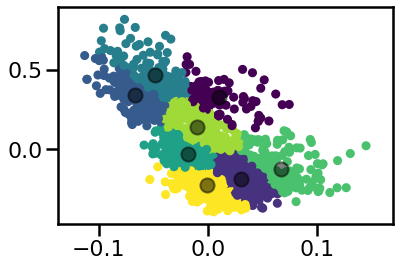

In [101]:
plt.scatter(Y2[:, 0], Y2[:, 1], c=labels, s=50, cmap='viridis')
centers = kmean.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

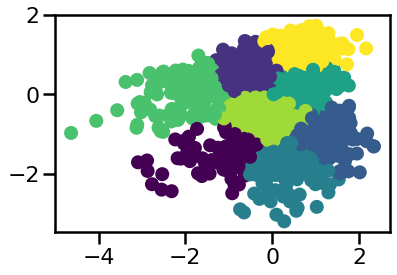

In [104]:
plt.scatter(ppca.e_X[:, 0], ppca.e_X[:, 1], c=labels)

In [117]:
group1 = (labels == 0)
cat1 = data_2[group1][['Player']]
#Data for just this specific cluster
cluster1 = data_2[group1].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)
league = data_2.drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster1, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,USG%,0.283001,26.132979,18.999174
1,3PA,0.267144,1.200973,3.823612
2,FT,0.267093,4.606036,2.627443
3,PTS,0.265722,23.143382,15.877855
4,3P,0.262684,0.405986,1.339083
5,3PAr,0.252523,0.061766,0.284952
6,FTA,0.249204,6.156694,3.517940
7,TOV,0.231068,2.745790,2.219402
8,AST%,0.230377,13.032979,13.828178
9,FGA,0.215072,18.067282,13.314768


This is the Franchise Bigman

In [118]:
group2 = (labels == 1)
cat2 = data_2[group2][['Player']]
#Data for just this specific cluster
cluster2 = data_2[group2].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster2, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.270215,13.141646,13.154761
1,AST,0.246803,4.816289,3.484363
2,AST%,0.231583,19.140898,13.828178
3,TOV,0.218196,2.469657,2.219402
4,STL%,0.157628,1.658354,1.585581
5,STL,0.155637,1.313920,1.255479
6,FTr,0.099172,0.241072,0.267914
7,2PA,0.077751,9.556095,9.491156
8,DRB%,0.062993,10.881297,14.917722
9,TRB%,0.060813,6.520449,9.943423


This is the all rounder guard

In [119]:
group3 = (labels == 2)
cat3 = data_2[group3][['Player']]
#Data for just this specific cluster
cluster3 = data_2[group3].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster3, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.261503,16.110778,13.154761
1,TRB%,0.248847,15.365868,9.943423
2,TRB,0.242610,10.993634,7.127916
3,DRB%,0.225920,20.336527,14.917722
4,DRB,0.223791,7.248046,5.338167
5,TOV,0.160639,1.915546,2.219402
6,ORB%,0.149148,10.432335,4.985636
7,ORB,0.139774,3.745588,1.789749
8,AST,0.095784,1.719804,3.484363
9,PF,0.095314,5.112413,3.567946


This is the Board Crashing Rebounder

In [120]:
group4 = (labels == 3)
cat4 = data_2[group4][['Player']]
#Data for just this specific cluster
cluster4 = data_2[group4].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster4, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,FTr,0.279799,0.412899,0.267914
1,FG%,0.249688,0.551953,0.449269
2,eFG%,0.247594,0.552480,0.499003
3,2P%,0.245570,0.554784,0.482768
4,TS%,0.234179,0.577243,0.533037
5,TRB%,0.151929,17.756081,9.943423
6,TRB,0.137661,12.718251,7.127916
7,DRB%,0.130338,23.660811,14.917722
8,DRB,0.130044,8.453651,5.338167
9,FTA,0.122619,4.730792,3.517940


This is the low post shooter

In [121]:
group5 = (labels == 4)
cat5 = data_2[group5][['Player']]
#Data for just this specific cluster
cluster5 = data_2[group5].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster5, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,3PA,0.318086,3.954429,3.823612
1,3P,0.317944,1.339872,1.339083
2,3PAr,0.294500,0.349515,0.284952
3,DRB,0.279495,5.335520,5.338167
4,DRB%,0.277387,14.861654,14.917722
5,TRB,0.256123,6.971273,7.127916
6,TRB%,0.252036,9.704135,9.943423
7,PTS,0.181085,12.736165,15.877855
8,FGA,0.166203,11.163933,13.314768
9,3P%,0.128121,0.325887,0.283027


This is the 3-D player

In [122]:
group6 = (labels == 5)
cat6 = data_2[group6][['Player']]
#Data for just this specific cluster
cluster6 = data_2[group6].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster6, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TRB%,0.283980,7.515730,9.943423
1,TRB,0.281444,5.383831,7.127916
2,DRB,0.268711,4.420746,5.338167
3,DRB%,0.265624,12.343258,14.917722
4,FG,0.252284,8.337235,5.955665
5,PTS,0.244407,23.759962,15.877855
6,weight,0.237503,92.567416,99.091910
7,USG%,0.216392,27.482584,18.999174
8,2P,0.214015,6.400916,4.616582
9,ORB%,0.203870,2.693258,4.985636


This is the Franchise Guard

In [123]:
group7 = (labels == 6)
cat7 = data_2[group7][['Player']]
#Data for just this specific cluster
cluster7 = data_2[group7].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster7, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,ORB%,0.227411,6.809091,4.985636
1,ORB,0.223183,2.446551,1.789749
2,TOV%,0.157692,12.022727,13.154761
3,FTr,0.153087,0.268045,0.267914
4,STL%,0.142549,1.520202,1.585581
5,STL,0.139119,1.205581,1.255479
6,FG%,0.120147,0.470823,0.449269
7,PF,0.105117,3.876715,3.567946
8,PER,0.090494,0.521355,0.524493
9,TRB%,0.062985,12.786364,9.943423


This is the Driving Forward

In [124]:
group8 = (labels == 7)
cat8 = data_2[group8][['Player']]
#Data for just this specific cluster
cluster8 = data_2[group8].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cluster8, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,AST,0.258931,3.432733,3.484363
1,AST%,0.256124,12.738904,13.828178
2,TOV%,0.250211,12.859726,13.154761
3,TOV,0.242816,1.775264,2.219402
4,2PA,0.143751,5.624604,9.491156
5,STL,0.123829,1.267734,1.255479
6,STL%,0.123816,1.608493,1.585581
7,2P,0.088965,2.462554,4.616582
8,FTr,0.078918,0.162663,0.267914
9,PF,0.056335,3.243425,3.567946


This is the Sixth Man

In [153]:
bb = pd.DataFrame({'X1':Y2[:,0],'X2':Y2[:,1], 'labels':labels})

player_list = list(data_2['Player'])
position_list = list(data_2['Pos'])
year_list = list(data_2['Year'])

In [154]:
bb['Player'] = player_list
bb['Pos'] = position_list
bb['Year'] = year_list
bb['labels'] = bb['labels'].map({0: 'Franchise Bigman',
                                 1: 'All Rounder Guard',
                                 2: 'Board Crashing Rebounder',
                                 3: 'Low Post Shooter',
                                 4: '3-D player',
                                 5: 'Franchise Guard',
                                 6: 'Driving Forward',
                                 7: 'Sixth Man'})

bb.head()

,X1,X2,labels,Player,Pos,Year
0,-0.072037,0.220351,Board Crashing Rebounder,Quincy Acy,SF,2014.0
1,-0.075552,0.231240,Board Crashing Rebounder,Quincy Acy,SF,2014.0
2,-0.085355,0.420361,Board Crashing Rebounder,Steven Adams,C,2014.0
3,-0.049797,0.413364,Low Post Shooter,Jeff Adrien,PF,2014.0
4,-0.033234,0.390783,Low Post Shooter,Jeff Adrien,PF,2014.0


In [155]:
bb.head(50)

,X1,X2,labels,Player,Pos,Year
0,-0.072037,0.220351,Board Crashing Rebounder,Quincy Acy,SF,2014.0
1,-0.075552,0.231240,Board Crashing Rebounder,Quincy Acy,SF,2014.0
2,-0.085355,0.420361,Board Crashing Rebounder,Steven Adams,C,2014.0
3,-0.049797,0.413364,Low Post Shooter,Jeff Adrien,PF,2014.0
4,-0.033234,0.390783,Low Post Shooter,Jeff Adrien,PF,2014.0
5,0.044732,-0.152186,All Rounder Guard,Arron Afflalo,SG,2014.0
6,-0.063673,0.443177,Low Post Shooter,Alexis Ajinca,C,2014.0
7,-0.094677,0.631043,Low Post Shooter,Cole Aldrich,C,2014.0
8,0.032210,0.294949,Franchise Bigman,LaMarcus Aldridge,PF,2014.0
9,-0.055639,0.257403,Board Crashing Rebounder,Lavoy Allen,PF,2014.0


In [156]:
bb.tail(50)

,X1,X2,labels,Player,Pos,Year
1767,0.018490,0.366710,Franchise Bigman,Karl-Anthony Towns,C,2017.0
1768,-0.034979,-0.050941,3-D player,P.J. Tucker,SF,2017.0
1769,-0.034098,-0.037298,3-D player,P.J. Tucker,SF,2017.0
1770,-0.039067,-0.075122,3-D player,P.J. Tucker,SF,2017.0
1771,0.008108,-0.082919,All Rounder Guard,Evan Turner,SF,2017.0
1772,-0.019500,0.278166,Driving Forward,Myles Turner,C,2017.0
1773,0.040989,-0.188953,All Rounder Guard,Beno Udrih,PG,2017.0
1774,0.046958,-0.267616,All Rounder Guard,Tyler Ulis,PG,2017.0
1775,-0.035175,0.453538,Low Post Shooter,Jonas Valanciunas,C,2017.0
1776,-0.006292,-0.274203,Sixth Man,Denzel Valentine,SG,2017.0


### Now for Gaussian as a comparision

In [51]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=8)
gmm.fit(X2)
new_labels = gmm.fit_predict(X2)

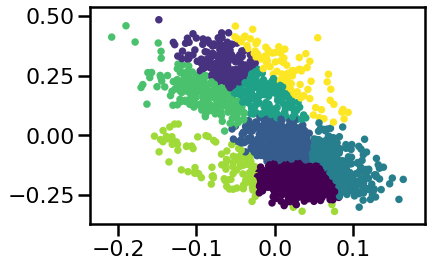

In [55]:
plt.scatter(X2[:, 0], X2[:, 1], c=new_labels, s=30, cmap='viridis');

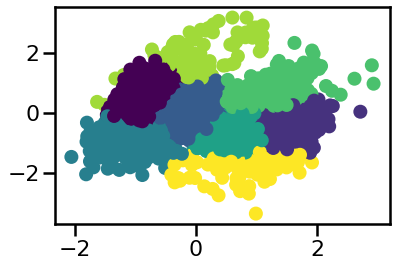

In [52]:
plt.scatter(ppca.e_X[:, 0], ppca.e_X[:, 1], c=new_labels)

In [106]:
g_1 = (new_labels == 0)
c_1 = data_1[g_1][['Player']]
#Data for just this specific cluster
cl_1 = data_1[g_1].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_1, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,3P,0.316924,1.847291,1.061632
1,3PAr,0.314286,0.352676,0.230770
2,3PA,0.280997,5.137804,3.034786
3,eFG%,0.234601,0.487984,0.490774
4,3P%,0.220749,0.353446,0.255069
5,TS%,0.189279,0.527717,0.526508
6,height,0.158724,192.205882,200.344018
7,weight,0.125074,89.052036,99.231254
8,FT%,0.104467,0.810043,0.733943
9,DRB,0.070911,3.266068,5.000089


I call this the Sharpshooting Wing

In [107]:
g_2 = (new_labels == 1)
c_2 = data_1[g_2][['Player']]
#Data for just this specific cluster
cl_2 = data_1[g_2].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_2, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,FGA,0.343119,11.165772,12.846253
1,2PA,0.340039,11.104239,9.811468
2,USG%,0.304271,17.172515,18.899828
3,FG,0.260811,5.874871,5.758079
4,2P,0.258602,5.865838,4.696447
5,PTS,0.215185,14.394301,15.213246
6,AST%,0.161814,5.494152,13.324785
7,AST,0.143855,1.366767,3.285199
8,3PA,0.107194,0.061533,3.034786
9,ORB,0.106332,4.106389,1.885994


This is the putback low poster

In [108]:
g_3 = (new_labels == 2)
c_3 = data_1[g_3][['Player']]
#Data for just this specific cluster
cl_3 = data_1[g_3].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_3, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,3P,0.307759,1.173606,1.061632
1,3PA,0.301264,3.426475,3.034786
2,3PAr,0.288521,0.255202,0.230770
3,DRB,0.263212,4.882553,5.000089
4,DRB%,0.261942,14.182051,14.474642
5,TRB%,0.258634,9.373718,9.951002
6,TRB,0.257844,6.493873,6.886083
7,3P%,0.189202,0.320971,0.255069
8,weight,0.162052,97.564103,99.231254
9,height,0.152561,201.375000,200.344018


I call this the all rounder

In [109]:
g_4 = (new_labels == 3)
c_4 = data_1[g_4][['Player']]
#Data for just this specific cluster
cl_4 = data_1[g_4].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_4, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.241182,13.477122,13.622954
1,TOV,0.232010,1.707266,2.216246
2,AST,0.216131,3.214786,3.285199
3,AST%,0.214378,12.072694,13.324785
4,2PA,0.175261,5.475972,9.811468
5,STL%,0.130778,1.600000,1.577619
6,2P,0.126623,2.348065,4.696447
7,STL,0.126411,1.227523,1.212297
8,FTr,0.122506,0.160970,0.283643
9,FTA,0.080142,1.632542,3.553760


I call this the sixth man

In [110]:
g_5 = (new_labels == 4)
c_5 = data_1[g_5][['Player']]
#Data for just this specific cluster
cl_5 = data_1[g_5].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_5, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,FTr,0.253157,0.309488,0.283643
1,TS%,0.220200,0.513380,0.526508
2,TOV%,0.215594,14.028916,13.622954
3,FG%,0.207760,0.473819,0.450417
4,2P%,0.189122,0.483705,0.475215
5,eFG%,0.182798,0.480127,0.490774
6,FTA,0.108015,3.058932,3.553760
7,FT,0.090440,2.066187,2.635455
8,PF,0.068992,4.843800,3.624738
9,STL,0.035784,1.073931,1.212297


I call this the bigman with a jumper

In [111]:
g_6 = (new_labels == 5)
c_6 = data_1[g_6][['Player']]
#Data for just this specific cluster
cl_6 = data_1[g_6].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_6, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,PTS,0.294213,19.616474,15.213246
1,USG%,0.293032,23.249457,18.899828
2,TRB%,0.290850,14.848370,9.951002
3,TRB,0.286913,10.298872,6.886083
4,DRB%,0.283419,20.743478,14.474642
5,DRB,0.278879,7.201470,5.000089
6,FG,0.272427,7.730582,5.758079
7,2P,0.249631,7.589335,4.696447
8,FGA,0.235587,15.572570,12.846253
9,2PA,0.223653,15.064867,9.811468


The franchise superstar

In [112]:
g_7 = (new_labels == 6)
c_7 = data_1[g_7][['Player']]
#Data for just this specific cluster
cl_7 = data_1[g_7].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_7, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,AST,0.091524,5.465333,3.285199
1,3PAr,0.081456,0.224303,0.230770
2,TOV%,0.075564,12.591743,13.622954
3,AST%,0.065910,24.370642,13.324785
4,PF,0.063109,2.739589,3.624738
5,PER,0.050285,0.448738,0.525508
6,3PA,0.046717,4.124155,3.034786
7,3P,0.024161,1.421742,1.061632
8,STL%,0.013706,1.796330,1.577619
9,STL,0.010531,1.379748,1.212297


The sharp shooting floor general

In [113]:
g_8 = (new_labels == 7)
c_8 = data_1[g_8][['Player']]
#Data for just this specific cluster
cl_8 = data_1[g_8].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_8, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.114240,20.605435,13.622954
1,3PAr,0.112321,0.021207,0.230770
2,3P,0.104028,0.041736,1.061632
3,3P%,0.103201,0.069250,0.255069
4,3PA,0.099447,0.148709,3.034786
5,FTr,0.064476,0.424261,0.283643
6,Unnamed: 0,0.063021,21079.978261,21087.791643
7,AST,0.033847,1.514166,3.285199
8,STL,0.033033,1.008681,1.212297
9,STL%,0.029653,1.318478,1.577619


This is the Loosehanded Bigman

In [90]:
aa = pd.DataFrame({'X1':X2[:,0],'X2':X2[:,1], 'labels':new_labels})

In [91]:
aa['Player'] = player_list
aa['Pos'] = position_list
aa['Year'] = year_list
aa['labels'] = aa['labels'].map({0: 'Sharpshooting Wing',
                                 1: 'Putback Lowposter',
                                 2: 'All Rounder',
                                 3: 'Sixth Man',
                                 4: 'Bigman with a Jumper',
                                 5: 'Franchise Superstar',
                                 6: 'Sharpshooting Floor General',
                                 7: 'Loosehanded Bigman'})

aa.head()

,X1,X2,labels,Player,Pos,Year
0,0.060338,-0.087310,Sixth Man,Arron Afflalo,SG,2010.0
1,-0.074306,0.120890,Franchise Superstar,LaMarcus Aldridge,PF,2010.0
2,0.039718,0.072859,Bigman with a Jumper,Malik Allen,PF,2010.0
3,0.009289,-0.130354,Sharpshooting Wing,Ray Allen,SG,2010.0
4,-0.033250,0.061435,All Rounder,Tony Allen,SG,2010.0


In [143]:
aa.head(50)

,X1,X2,labels,Player,Pos,Year
0,0.060338,-0.087310,Sixth Man,Arron Afflalo,SG,2010.0
1,-0.074306,0.120890,Franchise Superstar,LaMarcus Aldridge,PF,2010.0
2,0.039718,0.072859,Bigman with a Jumper,Malik Allen,PF,2010.0
3,0.009289,-0.130354,Sharpshooting Wing,Ray Allen,SG,2010.0
4,-0.033250,0.061435,All Rounder,Tony Allen,SG,2010.0
5,0.083730,-0.231517,Sixth Man,Rafer Alston,PG,2010.0
6,0.058429,-0.234778,Sharpshooting Wing,Rafer Alston,PG,2010.0
7,0.113042,-0.219478,Sixth Man,Rafer Alston,PG,2010.0
8,-0.055231,0.338485,Putback Lowposter,Lou Amundson,PF,2010.0
9,-0.054714,0.379768,Putback Lowposter,Chris Andersen,PF,2010.0


In [144]:
aa.tail(50)

,X1,X2,labels,Player,Pos,Year
1697,0.002186,0.013863,All Rounder,Tyrus Thomas,PF,2013.0
1698,-0.040848,0.138830,Bigman with a Jumper,Jason Thompson,PF,2013.0
1699,0.034054,-0.178075,Sharpshooting Wing,Klay Thompson,SG,2013.0
1700,-0.062065,0.252318,Putback Lowposter,Tristan Thompson,PF,2013.0
1701,0.022364,-0.216431,Sharpshooting Wing,Marcus Thornton,SG,2013.0
1702,0.118685,-0.223224,Sixth Man,Jamaal Tinsley,PG,2013.0
1703,0.078631,-0.059169,Sixth Man,Anthony Tolliver,SF,2013.0
1704,0.034645,0.036793,All Rounder,P.J. Tucker,SG,2013.0
1705,0.017229,0.260158,Loosehanded Bigman,Ronny Turiaf,C,2013.0
1706,0.002586,-0.057801,All Rounder,Evan Turner,SF,2013.0


In [157]:
gmm = GaussianMixture(n_components=8)
gmm.fit(Y2)
new_labels = gmm.fit_predict(Y2)

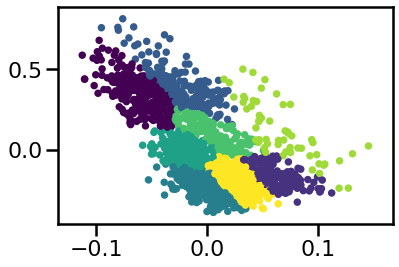

In [158]:
plt.scatter(Y2[:, 0], Y2[:, 1], c=new_labels, s=30, cmap='viridis');

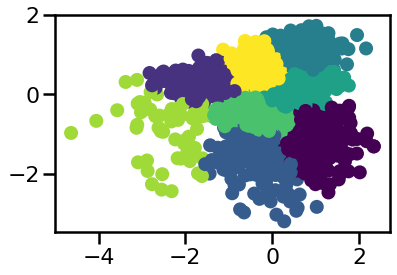

In [159]:
plt.scatter(ppca.e_X[:, 0], ppca.e_X[:, 1], c=new_labels)

In [160]:
g_1 = (new_labels == 0)
c_1 = data_2[g_1][['Player']]
#Data for just this specific cluster
cl_1 = data_2[g_1].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_1, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.272374,15.356400,13.154761
1,TRB%,0.223060,15.539600,9.943423
2,TRB,0.220852,11.092812,7.127916
3,DRB%,0.195522,20.628400,14.917722
4,DRB,0.192220,7.346297,5.338167
5,ORB%,0.160183,10.475200,4.985636
6,ORB,0.157112,3.746516,1.789749
7,FTr,0.139688,0.382092,0.267914
8,TOV,0.135149,1.928394,2.219402
9,PF,0.104124,4.947313,3.567946


Relentless Scorer

In [161]:
g_2 = (new_labels == 1)
c_2 = data_2[g_2][['Player']]
#Data for just this specific cluster
cl_2 = data_2[g_2].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_2, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.238309,13.365089,13.154761
1,TOV,0.172051,3.116918,2.219402
2,TRB%,0.151712,6.498817,9.943423
3,TRB,0.150326,4.678466,7.127916
4,DRB%,0.147441,10.905325,14.917722
5,AST%,0.143982,26.733136,13.828178
6,AST,0.143709,6.323484,3.484363
7,STL%,0.137849,1.873373,1.585581
8,STL,0.132126,1.486149,1.255479
9,DRB,0.131926,3.902183,5.338167


Playmaking Forward

In [162]:
g_3 = (new_labels == 2)
c_3 = data_2[g_3][['Player']]
#Data for just this specific cluster
cl_3 = data_2[g_3].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_3, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,FTr,0.242941,0.363038,0.267914
1,FG%,0.233088,0.528228,0.449269
2,2P%,0.220586,0.533723,0.482768
3,eFG%,0.218683,0.531734,0.499003
4,ORB%,0.195567,10.636957,4.985636
5,ORB,0.189607,3.828906,1.789749
6,TRB%,0.177833,16.887500,9.943423
7,TS%,0.177786,0.562217,0.533037
8,TRB,0.175096,12.128912,7.127916
9,BLK%,0.147793,3.270109,1.601871


Post Scorer

In [164]:
g_4 = (new_labels == 3)
c_4 = data_2[g_4][['Player']]
#Data for just this specific cluster
cl_4 = data_2[g_4].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_4, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,AST,0.256587,3.320261,3.484363
1,AST%,0.254857,12.260831,13.828178
2,TOV%,0.245574,12.905341,13.154761
3,TOV,0.239737,1.730714,2.219402
4,2PA,0.154836,5.400893,9.491156
5,STL,0.135652,1.255808,1.255479
6,STL%,0.135084,1.595549,1.585581
7,2P,0.096052,2.359287,4.616582
8,FTr,0.079224,0.162985,0.267914
9,PF,0.048293,3.271914,3.567946


Reserve Facilitator

In [165]:
g_5 = (new_labels == 4)
c_5 = data_2[g_5][['Player']]
#Data for just this specific cluster
cl_5 = data_2[g_5].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_5, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,FG%,0.189231,0.436984,0.449269
1,TOV%,0.158482,12.706827,13.154761
2,FTr,0.132970,0.230542,0.267914
3,AST,0.131756,2.545679,3.484363
4,AST%,0.125597,9.497189,13.828178
5,2P%,0.094996,0.491305,0.482768
6,2P,0.094962,3.613087,4.616582
7,STL%,0.094060,1.614458,1.585581
8,STL,0.090019,1.284823,1.255479
9,2PA,0.052515,7.435328,9.491156


Driving Guard

In [166]:
g_6 = (new_labels == 5)
c_6 = data_2[g_6][['Player']]
#Data for just this specific cluster
cl_6 = data_2[g_6].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_6, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TRB,0.303850,8.715062,7.127916
1,TRB%,0.297112,12.158553,9.943423
2,DRB,0.235831,6.542292,5.338167
3,ORB,0.233015,2.172770,1.789749
4,ORB%,0.230242,6.032237,4.985636
5,DRB%,0.225093,18.338816,14.917722
6,PF,0.214062,3.578278,3.567946
7,height,0.155546,205.539474,200.521739
8,BLK,0.153941,1.016247,0.796705
9,BLK%,0.149904,2.054605,1.601871


Rebounding Bigman

In [167]:
g_7 = (new_labels == 6)
c_7 = data_2[g_7][['Player']]
#Data for just this specific cluster
cl_7 = data_2[g_7].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_7, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,3PAr,0.240778,0.198052,0.284952
1,3PA,0.237518,4.202287,3.823612
2,3P,0.227637,1.498000,1.339083
3,AST,0.219821,5.430496,3.484363
4,AST%,0.216818,24.562069,13.828178
5,3P%,0.161637,0.323052,0.283027
6,FT%,0.146042,0.807483,0.744484
7,STL,0.141913,1.491423,1.255479
8,STL%,0.140066,1.875862,1.585581
9,TOV%,0.117028,12.313793,13.154761


Sharpshooting Floor General

In [168]:
g_8 = (new_labels == 7)
c_8 = data_2[g_8][['Player']]
#Data for just this specific cluster
cl_8 = data_2[g_8].drop(['Player', 'Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

feature_importance(cl_8, league).reset_index().drop('index', axis=1)

,Stat,Correlation,Cluster Average,League Average
0,TOV%,0.272369,13.058373,13.154761
1,AST,0.251439,4.562468,3.484363
2,AST%,0.238589,17.924163,13.828178
3,TOV,0.223489,2.366919,2.219402
4,STL%,0.153796,1.665311,1.585581
5,STL,0.151099,1.318416,1.255479
6,FTr,0.102081,0.227134,0.267914
7,2PA,0.074544,9.043773,9.491156
8,PF,0.066143,3.067878,3.567946
9,TRB%,0.032850,6.517943,9.943423


All Rounder

In [176]:
cc = pd.DataFrame({'X1':Y2[:,0],'X2':Y2[:,1], 'labels':new_labels})

In [177]:
cc['Player'] = player_list
cc['Pos'] = position_list
cc['Year'] = year_list
cc['labels'] = cc['labels'].map({0: 'Relentless Scorer',
                                 1: 'Playmaking Forward',
                                 2: 'Post Scorer',
                                 3: 'Reserve Facilitator',
                                 4: 'Driving Guard',
                                 5: 'Rebounding Bigman',
                                 6: 'Sharpshooting Floor General',
                                 7: 'All Rounder'})

cc.head()

,X1,X2,labels,Player,Pos,Year
0,-0.072037,0.220351,Relentless Scorer,Quincy Acy,SF,2014.0
1,-0.075552,0.231240,Relentless Scorer,Quincy Acy,SF,2014.0
2,-0.085355,0.420361,Relentless Scorer,Steven Adams,C,2014.0
3,-0.049797,0.413364,Relentless Scorer,Jeff Adrien,PF,2014.0
4,-0.033234,0.390783,Post Scorer,Jeff Adrien,PF,2014.0


In [178]:
cc.head(50)

,X1,X2,labels,Player,Pos,Year
0,-0.072037,0.220351,Relentless Scorer,Quincy Acy,SF,2014.0
1,-0.075552,0.231240,Relentless Scorer,Quincy Acy,SF,2014.0
2,-0.085355,0.420361,Relentless Scorer,Steven Adams,C,2014.0
3,-0.049797,0.413364,Relentless Scorer,Jeff Adrien,PF,2014.0
4,-0.033234,0.390783,Post Scorer,Jeff Adrien,PF,2014.0
5,0.044732,-0.152186,Playmaking Forward,Arron Afflalo,SG,2014.0
6,-0.063673,0.443177,Relentless Scorer,Alexis Ajinca,C,2014.0
7,-0.094677,0.631043,Relentless Scorer,Cole Aldrich,C,2014.0
8,0.032210,0.294949,Sharpshooting Floor General,LaMarcus Aldridge,PF,2014.0
9,-0.055639,0.257403,Relentless Scorer,Lavoy Allen,PF,2014.0


In [179]:
cc.tail(50)

,X1,X2,labels,Player,Pos,Year
1767,0.018490,0.366710,Post Scorer,Karl-Anthony Towns,C,2017.0
1768,-0.034979,-0.050941,Driving Guard,P.J. Tucker,SF,2017.0
1769,-0.034098,-0.037298,Driving Guard,P.J. Tucker,SF,2017.0
1770,-0.039067,-0.075122,Driving Guard,P.J. Tucker,SF,2017.0
1771,0.008108,-0.082919,All Rounder,Evan Turner,SF,2017.0
1772,-0.019500,0.278166,Post Scorer,Myles Turner,C,2017.0
1773,0.040989,-0.188953,All Rounder,Beno Udrih,PG,2017.0
1774,0.046958,-0.267616,All Rounder,Tyler Ulis,PG,2017.0
1775,-0.035175,0.453538,Post Scorer,Jonas Valanciunas,C,2017.0
1776,-0.006292,-0.274203,Reserve Facilitator,Denzel Valentine,SG,2017.0


### Choosing which model to Compare

As we have seen from the plots for KMeans and GMM. The clusters are not exactly circular and for that reason, I am going to use the Gaussian model to compare the 2010-2013 to the 2014-2017 player data

### For 2010-2013 GMM

In [328]:
#Y = data_2.drop(['Pos', 'Year', 'Age','G', 'GS', 'MP'], axis=1)

aa_1 = aa[(aa['Pos'] == 'PG')]
aa_12 = aa_1.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [327]:
a1 = aa_12[(aa_12['labels'] == "Sharpshooting Wing")]
print(np.shape(a1))
a1 = aa_12[(aa_12['labels'] == "Putback Lowposter")]
print(np.shape(a1))
a1 = aa_12[(aa_12['labels'] == "All Rounder")]
print(np.shape(a1))
a1 = aa_12[(aa_12['labels'] == "Sixth Man")]
print(np.shape(a1))
a1 = aa_12[(aa_12['labels'] == "Bigman with a Jumper")]
print(np.shape(a1))
a1 = aa_12[(aa_12['labels'] == "Franchise Superstar")]
print(np.shape(a1))
a1 = aa_12[(aa_12['labels'] == "Sharpshooting Floor General")]
print(np.shape(a1))
a1 = aa_12[(aa_12['labels'] == "Loosehanded Bigman")]
print(np.shape(a1))

(220, 1)
(0, 1)
(18, 1)
(68, 1)
(0, 1)
(0, 1)
(33, 1)
(0, 1)


The PG is a mixture of the sharpshooting wing and sixth man.

In [326]:
aa_2 = aa[(aa['Pos'] == 'SG')]
aa_22 = aa_2.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [325]:
a2 = aa_22[(aa_22['labels'] == "Sharpshooting Wing")]
print(np.shape(a2))
a2 = aa_22[(aa_22['labels'] == "Putback Lowposter")]
print(np.shape(a2))
a2 = aa_22[(aa_22['labels'] == "All Rounder")]
print(np.shape(a2))
a2 = aa_22[(aa_22['labels'] == "Sixth Man")]
print(np.shape(a2))
a2 = aa_22[(aa_22['labels'] == "Bigman with a Jumper")]
print(np.shape(a2))
a2 = aa_22[(aa_22['labels'] == "Franchise Superstar")]
print(np.shape(a2))
a2 = aa_22[(aa_22['labels'] == "Sharpshooting Floor General")]
print(np.shape(a2))
a2 = aa_22[(aa_22['labels'] == "Loosehanded Bigman")]
print(np.shape(a2))

(171, 1)
(0, 1)
(65, 1)
(73, 1)
(4, 1)
(0, 1)
(42, 1)
(0, 1)


The SG is a mixture of sharpshooting wing, sixth man, and all rounder.

In [323]:
aa_3 = aa[(aa['Pos'] == 'SF')]
aa_32 = aa_3.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [324]:
a3 = aa_32[(aa_32['labels'] == "Sharpshooting Wing")]
print(np.shape(a3))
a3 = aa_32[(aa_32['labels'] == "Putback Lowposter")]
print(np.shape(a3))
a3 = aa_32[(aa_32['labels'] == "All Rounder")]
print(np.shape(a3))
a3 = aa_32[(aa_32['labels'] == "Sixth Man")]
print(np.shape(a3))
a3 = aa_32[(aa_32['labels'] == "Bigman with a Jumper")]
print(np.shape(a3))
a3 = aa_32[(aa_32['labels'] == "Franchise Superstar")]
print(np.shape(a3))
a3 = aa_32[(aa_32['labels'] == "Sharpshooting Floor General")]
print(np.shape(a3))
a3 = aa_32[(aa_32['labels'] == "Loosehanded Bigman")]
print(np.shape(a3))

(39, 1)
(1, 1)
(156, 1)
(103, 1)
(14, 1)
(2, 1)
(24, 1)
(3, 1)


The small forward is a mixture of all rounder and sixth man.

In [322]:
aa_4 = aa[(aa['Pos'] == 'C')]
aa_42 = aa_4.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [321]:
a4 = aa_42[(aa_42['labels'] == "Sharpshooting Wing")]
print(np.shape(a4))
a4 = aa_42[(aa_42['labels'] == "Putback Lowposter")]
print(np.shape(a4))
a4 = aa_42[(aa_42['labels'] == "All Rounder")]
print(np.shape(a4))
a4 = aa_42[(aa_42['labels'] == "Sixth Man")]
print(np.shape(a4))
a4 = aa_42[(aa_42['labels'] == "Bigman with a Jumper")]
print(np.shape(a4))
a4 = aa_42[(aa_42['labels'] == "Franchise Superstar")]
print(np.shape(a4))
a4 = aa_42[(aa_42['labels'] == "Sharpshooting Floor General")]
print(np.shape(a4))
a4 = aa_42[(aa_42['labels'] == "Loosehanded Bigman")]
print(np.shape(a4))

(0, 1)
(115, 1)
(6, 1)
(1, 1)
(65, 1)
(74, 1)
(2, 1)
(68, 1)


The Center is mixture of the putback lowposter, loosehanded bigman, and franchise superstar

In [320]:
aa_5 = aa[(aa['Pos'] == 'PF')]
aa_52 = aa_5.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [319]:
a5 = aa_52[(aa_52['labels'] == "Sharpshooting Wing")]
print(np.shape(a5))
a5 = aa_52[(aa_52['labels'] == "Putback Lowposter")]
print(np.shape(a5))
a5 = aa_52[(aa_52['labels'] == "All Rounder")]
print(np.shape(a5))
a5 = aa_52[(aa_52['labels'] == "Sixth Man")]
print(np.shape(a5))
a5 = aa_52[(aa_52['labels'] == "Bigman with a Jumper")]
print(np.shape(a5))
a5 = aa_52[(aa_52['labels'] == "Franchise Superstar")]
print(np.shape(a5))
a5 = aa_52[(aa_52['labels'] == "Sharpshooting Floor General")]
print(np.shape(a5))
a5 = aa_52[(aa_52['labels'] == "Loosehanded Bigman")]
print(np.shape(a5))

(2, 1)
(53, 1)
(56, 1)
(18, 1)
(80, 1)
(104, 1)
(7, 1)
(19, 1)


The PF is a mixture of Franchise Superstar and Bigman with a Jumper

### For 2014-2017 GMM

In [312]:
cc_1 = cc[(cc['Pos'] == 'PG')]
cc_12 = cc_1.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [318]:
c1 = cc_12[(cc_12['labels'] == "Post Scorer")]
print(np.shape(c1))
c1 = cc_12[(cc_12['labels'] == "Relentless Scorer")]
print(np.shape(c1))
c1 = cc_12[(cc_12['labels'] == "Playmaking Forward")]
print(np.shape(c1))
c1 = cc_12[(cc_12['labels'] == "Reserve Facilitator")]
print(np.shape(c1))
c1 = cc_12[(cc_12['labels'] == "Driving Guard")]
print(np.shape(c1))
c1 = cc_12[(cc_12['labels'] == "Rebounding Bigman")]
print(np.shape(c1))
c1 = cc_12[(cc_12['labels'] == "All Rounder")]
print(np.shape(c1))
c1 = cc_12[(cc_12['labels'] == "Sharpshooting Floor General")]
print(np.shape(c1))

(1, 1)
(0, 1)
(100, 1)
(86, 1)
(8, 1)
(1, 1)
(168, 1)
(8, 1)


The PG is a mixture of the all rounder and playmaking forward

In [310]:
cc_2 = cc[(cc['Pos'] == 'SG')]
cc_22 = cc_2.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [317]:
c2 = cc_22[(cc_22['labels'] == "Post Scorer")]
print(np.shape(c2))
c2 = cc_22[(cc_22['labels'] == "Relentless Scorer")]
print(np.shape(c2))
c2 = cc_22[(cc_22['labels'] == "Playmaking Forward")]
print(np.shape(c2))
c2 = cc_22[(cc_22['labels'] == "Reserve Facilitator")]
print(np.shape(c2))
c2 = cc_22[(cc_22['labels'] == "Driving Guard")]
print(np.shape(c2))
c2 = cc_22[(cc_22['labels'] == "Rebounding Bigman")]
print(np.shape(c2))
c2 = cc_22[(cc_22['labels'] == "All Rounder")]
print(np.shape(c2))
c2 = cc_22[(cc_22['labels'] == "Sharpshooting Floor General")]
print(np.shape(c2))

(0, 1)
(2, 1)
(51, 1)
(126, 1)
(17, 1)
(10, 1)
(160, 1)
(9, 1)


The SG is a mixture of the all rounder and reserve facilitator

In [308]:
cc_3 = cc[(cc['Pos'] == 'SF')]
cc_32 = cc_3.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [316]:
c3 = cc_32[(cc_32['labels'] == "Post Scorer")]
print(np.shape(c3))
c3 = cc_32[(cc_32['labels'] == "Relentless Scorer")]
print(np.shape(c3))
c3 = cc_32[(cc_32['labels'] == "Playmaking Forward")]
print(np.shape(c3))
c3 = cc_32[(cc_32['labels'] == "Reserve Facilitator")]
print(np.shape(c3))
c3 = cc_32[(cc_32['labels'] == "Driving Guard")]
print(np.shape(c3))
c3 = cc_32[(cc_32['labels'] == "Rebounding Bigman")]
print(np.shape(c3))
c3 = cc_32[(cc_32['labels'] == "All Rounder")]
print(np.shape(c3))
c3 = cc_32[(cc_32['labels'] == "Sharpshooting Floor General")]
print(np.shape(c3))

(0, 1)
(7, 1)
(16, 1)
(107, 1)
(111, 1)
(30, 1)
(72, 1)
(17, 1)


The SF was a mix between a reserve facilitator, driving guard, and all rounder

In [306]:
cc_4 = cc[(cc['Pos'] == 'C')]
cc_42 = cc_4.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [315]:
c4 = cc_42[(cc_42['labels'] == "Post Scorer")]
print(np.shape(c4))
c4 = cc_42[(cc_42['labels'] == "Relentless Scorer")]
print(np.shape(c4))
c4 = cc_42[(cc_42['labels'] == "Playmaking Forward")]
print(np.shape(c4))
c4 = cc_42[(cc_42['labels'] == "Reserve Facilitator")]
print(np.shape(c4))
c4 = cc_42[(cc_42['labels'] == "Driving Guard")]
print(np.shape(c4))
c4 = cc_42[(cc_42['labels'] == "Rebounding Bigman")]
print(np.shape(c4))
c4 = cc_42[(cc_42['labels'] == "All Rounder")]
print(np.shape(c4))
c4 = cc_42[(cc_42['labels'] == "Sharpshooting Floor General")]
print(np.shape(c4))

(121, 1)
(155, 1)
(0, 1)
(0, 1)
(8, 1)
(28, 1)
(1, 1)
(12, 1)


The Center is a mixture of a relentless scorer and post scorer

In [304]:
cc_5 = cc[(cc['Pos'] == 'PF')]
cc_52 = cc_5.drop(['X1','X2','Player','Pos','Year'], axis=1)

In [314]:
c5 = cc_52[(cc_52['labels'] == "Post Scorer")]
print(np.shape(c5))
c5 = cc_52[(cc_52['labels'] == "Relentless Scorer")]
print(np.shape(c5))
c5 = cc_52[(cc_52['labels'] == "Playmaking Forward")]
print(np.shape(c5))
c5 = cc_52[(cc_52['labels'] == "Reserve Facilitator")]
print(np.shape(c5))
c5 = cc_52[(cc_52['labels'] == "Driving Guard")]
print(np.shape(c5))
c5 = cc_52[(cc_52['labels'] == "Rebounding Bigman")]
print(np.shape(c5))
c5 = cc_52[(cc_52['labels'] == "All Rounder")]
print(np.shape(c5))
c5 = cc_52[(cc_52['labels'] == "Sharpshooting Floor General")]
print(np.shape(c5))

(62, 1)
(86, 1)
(1, 1)
(15, 1)
(100, 1)
(83, 1)
(14, 1)
(12, 1)


The Power Forward is a mix of Relentless Scorer, Driving Guard, and Rebounding Bigman